# Исследование рынка недвижимости Санкт-Петербурга на основе объявлений о продаже квартир

<b>Контекст проекта:</b> <br>В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно определить зависимость рыночной стоимости объектов недвижимости от различных параметров: от расстояния от центра, от площади квартиры, от количества комнат и т.д. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Импорт необходимых библиотек и данных для анализа 

In [6]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# импорт и знакомство с данными
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
# просмотр первых пяти записей
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


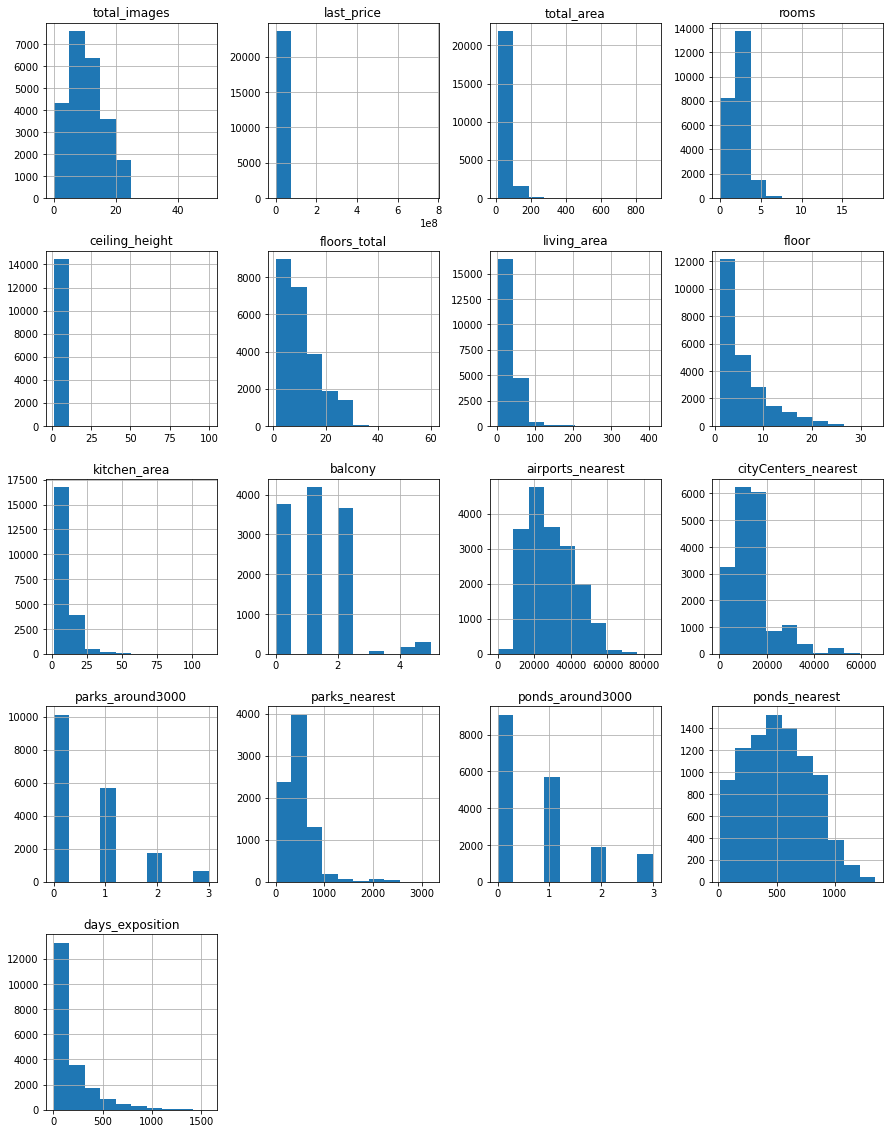

In [7]:
# посмотрим на "ознакомительные" гистограммы по всем полям
df.hist(figsize=(15, 20))
plt.show()

In [4]:
df.shape

(23699, 22)

**<font color="maroon">В датафрейме 22 колонки и 23699 строк. Колонка total_images хорошо без пропусков заполнена, но в предстоящем анализе мы её не будем использовать. В колонке last_price сразу видно по гистограмме что есть очень мало очень больших значений, их мы исключим из анализа, так как редкие явления не помогают описывать казуальные явления. То же можно сказать про колонки содержащие информацию о площадях (общую, жилую, кухни), и о количестве комнат: будем исключать выбросы. Перед этим поработаем спропусками, с типами данных. В конце проведём исследовательский анализ данных на предмет поиска основных параметров влияющих на цену квартир.</font>**

<div class="alert alert-block alert-warning">
 
### Комментарий ревьюера
    
#### Совет

Классно, что ты вывел распределение по каждому столбцу. В конца знакомства с данными принято добавлять информацию о том, что мы обнаружили в ходе знакомства с датасетом. А еще, примерно накидывают план дальнейших действий. 
</div 

### Предобработка данных

**2.1 Подсчёт количества пропусков по столбцам**

In [5]:
#len(df) - 23699 всего строк
#df['total_images'].isna().sum() - 0
#df['last_price'].isna().sum() - 0
#df['total_area'].isna().sum() - 0
#df['first_day_exposition'].isna().sum() - 0
#df['rooms'].isna().sum() - 0
#df['ceiling_height'].isna().sum() - 9195
#df['floors_total'].isna().sum() - 86
#df['living_area'].isna().sum() - 1903
#df['floor'].isna().sum() - 0
#df['is_apartment'].isna().sum() - 20924
#df['is_apartment'].value_counts()
#df['studio'].isna().sum() - 0
#df['open_plan'].isna().sum() - 0
#df['kitchen_area'].isna().sum() - 2278
#df['balcony'].isna().sum() - 11519
df['balcony'] = df['balcony'].fillna(0) # заменили пропуски в этом столбце на 0
#df['balcony'].isna().sum() - 0
#df['locality_name'].isna().sum() - 49
#df['airports_nearest'].isna().sum() - 5542
#df['cityCenters_nearest'].isna().sum() - 5519
#df['parks_around3000'].isna().sum() - 5518
#df['parks_nearest'].isna().sum() - 15620
#df['ponds_around3000'].isna().sum() - 5518
#df['ponds_nearest'].isna().sum() - 14589
#df['days_exposition'].isna().sum() - 3181

- Пропуски в колонке высота потолка имеются почти в 9195 строках, продавцы не посчитали важным указать высоту потолка, т.к. возможно у них стандартная высота потолков, **<font color="maroon">возможно люди не знают высоту своих потолков, возможно баг</font>**;
- **<font color="maroon">Пропуски в колонке количество этажей встречаются 86 раз. Предположу что эти люди не знают этажность своего дома.</font>**
- Жилая площадь не указана у 1903 квартир, возможно это квартиры выведенные из жилого фонда, или апартаменты;
- 20924 пропусков встречается в столбце 'is_apartment', **<font color="maroon">возможно люди, как и я, не знают что такое апартаменты, возможно баг</font>**;
- В столбце площадь кухни 2278 пропусков, возможно это квартиры без отдельной кухни, **<font color="maroon">возможно люди не знают площадь кухни, возможно баг</font>**;
- 11519 пропусков в столбце 'balcony', согласно условию пропуск означает отсутствие балкона - заменили эти пропуски на 0;
- 49 пропусков в названии населённого пункта, ~~не могу понять причину, мне кажется ни о чём не говорят эти пропуски~~ **<font color="maroon">думаю 49 человек не указали населённый пункт</font>**;
- 5542 - в столбце 'airports_nearest', ~~не могу понять причину, мне кажется ни о чём не говорят эти пропуски~~ **<font color="maroon">так как эта картографическая информация, возможно пользователь не указал адрес, или указал неточный/неполный адрес, или картографическая система дала сбой при определении местонахождения квартиры.</font>**;
- 5519 - в столбце 'cityCenters_nearest' ~~не могу понять причину, мне кажется ни о чём не говорят эти пропуски~~ **<font color="maroon">так как эта картографическая информация, возможно пользователь не указал адрес, или указал неточный/неполный адрес, или картографическая система дала сбой при определении местонахождения квартиры.</font>**;
- 5518 - в столбце 'parks_around3000' ~~не могу понять причину, мне кажется ни о чём не говорят эти пропуски~~ **<font color="maroon">так как эта картографическая информация, возможно пользователь не указал адрес, или указал неточный/неполный адрес, или картографическая система дала сбой при определении местонахождения квартиры.</font>**;
- 15620 - в столбце 'parks_nearest' ~~не могу понять причину, мне кажется ни о чём не говорят эти пропуски~~ **<font color="maroon">так как эта картографическая информация, возможно пользователь не указал адрес, или указал неточный/неполный адрес, или картографическая система дала сбой при определении местонахождения квартиры.</font>**;
- 5518 - в столбце 'ponds_around3000' ~~не могу понять причину, мне кажется ни о чём не говорят эти пропуски~~ **<font color="maroon">так как эта картографическая информация, возможно пользователь не указал адрес, или указал неточный/неполный адрес, или картографическая система дала сбой при определении местонахождения квартиры.</font>**;
- 14589 - в столбце 'ponds_nearest' ~~не могу понять причину, мне кажется ни о чём не говорят эти пропуски~~ **<font color="maroon">так как эта картографическая информация, возможно пользователь не указал адрес, или указал неточный/неполный адрес, или картографическая система дала сбой при определении местонахождения квартиры.</font>**;
- 3181 - в столбце 'days_exposition' ~~не могу понять причину, мне кажется ни о чём не говорят эти пропуски~~ **<font color="maroon">Возможно данные квартиры ещё не проданы поэтому, так как неизвестна конечная дата, продолжительность экспозиции не посчиталась.</font>**;

<div class="alert alert-block alert-danger">
 
### Комментарий ревьюера
    
#### Ошибка
    
А вот тут можно посмотреть на данные более детально. Напримерно, у тебя есть пропуски в высоте потолков. Обычно, высота потолкой в домах +- стандартизированна. Это значит, тут можно заменить пропуски медианой и мы нигде сильно не отобьемся от общей логики. Дальше ты это сделаешь, но это просто как один из примеров проработки замены пропусков.


Теперь о причинах возникновения. Так просто не пойдет. Вот смотри, пропуски в той же высоте потолков наверняка вызваны тем, что люди при заполнении объявления просто ее не знают. Вот по плодащям тут уже два фактора может быть. Люди не знают точно, сколько у них площадь кухни или жилая, и возможен технический баг, когда данные просто не доехали.
    
    
Пропуски это очень ценная вещь, которая может сказать о многом. Важно пройтись хотя бы по основным столбцам. Попробуй высказать предположения.  
</div 

<div class="alert alert-block alert-success">
 
# Комментарий ревьюера ver.2
    
#### Успех
    
Здесь отлично теперь получилось
</div 

**2.2 Работа с типами данных**

В столбце first_day_exposition указана дата размещения объявления, поменяем тип на datetime, при этом уберём бесполезные нули в H M S:

In [6]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d')
df['first_day_exposition']

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_exposition, Length: 23699, dtype: datetime64[ns]

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Тут отличный перевод данных в формат даты. 
</div 

Столбец days_exposition тоже переведём в datetime формат, не трогая пропуски:

In [7]:
df['days_exposition_formatted'] = pd.to_timedelta(df[~df['days_exposition'].isna()]['days_exposition'].astype(int), unit='d')
df['days_exposition_formatted']

0            NaT
1        81 days
2       558 days
3       424 days
4       121 days
          ...   
23694        NaT
23695    45 days
23696        NaT
23697   602 days
23698        NaT
Name: days_exposition_formatted, Length: 23699, dtype: timedelta64[ns]

Колонку с количеством балконов переведём в тип int:

In [8]:
df['balcony'] = df['balcony'].astype('int32')
df['balcony']

0        0
1        2
2        0
3        0
4        0
        ..
23694    0
23695    0
23696    0
23697    2
23698    0
Name: balcony, Length: 23699, dtype: int32

<div class="alert alert-block alert-warning">
 
### Комментарий ревьюера
    
#### Совет
    
Для экономии вычислительной памяти можно перевести в формат int32 
</div 

**<font color="maroon">Заменил на int32. Но наш наставник Глеб Михайлов утверждал, что аналитикам данных в 99% случаев нету дела до экономии памяти и заботы о быстродействии кода.</font>**

<div class="alert alert-block alert-success">
 
# Комментарий ревьюера ver.2
    
#### Успех
    
Ну да, это лишь просто рекомендация на будущее:) Вдруг столкнешься
</div 

**2.3 Дубликаты в названиях населенных пунктов**

In [9]:
df.duplicated(subset='locality_name').value_counts()

True     23334
False      365
dtype: int64

In [10]:
pd.set_option('display.max_rows', df.shape[0]+1)
df.value_counts('locality_name')

locality_name
Санкт-Петербург                                            15721
посёлок Мурино                                               522
посёлок Шушары                                               440
Всеволожск                                                   398
Пушкин                                                       369
Колпино                                                      338
посёлок Парголово                                            327
Гатчина                                                      307
деревня Кудрово                                              299
Выборг                                                       237
Петергоф                                                     201
Сестрорецк                                                   183
Красное Село                                                 178
Кудрово                                                      173
деревня Новое Девяткино                                      144
Сертолово  

In [11]:
len(df.value_counts('locality_name'))

364

In [12]:
df['clean_locality_name'] = df['locality_name']
to_replace = ['деревня ', 'село ', 'посёлок ', 'поселок ', 'городской посёлок ', 'городской поселок ', 'посёлок городского типа ',
             'поселок городского типа ', 'садоводческое некоммерческое товарищество ', 'садовое товарищество ', 'коттеджный посёлок ',
              'коттеджный ', 'городского типа ', 'станции ', 'при железнодорожной станции ', 'при железнодорожной ', 'городской ']
for x in to_replace:
    df['clean_locality_name'] = df['clean_locality_name'].replace(x,'', regex=True)
df.value_counts('clean_locality_name')

clean_locality_name
Санкт-Петербург            15721
Мурино                       590
Кудрово                      472
Шушары                       440
Всеволожск                   398
Пушкин                       369
Колпино                      338
Парголово                    327
Гатчина                      307
Выборг                       237
Петергоф                     201
Сестрорецк                   183
Красное Село                 178
Новое Девяткино              144
Сертолово                    142
Ломоносов                    133
Кириши                       125
Бугры                        114
Сланцы                       112
Волхов                       111
Кингисепп                    104
Тосно                        104
Кронштадт                     96
Никольское                    94
Коммунар                      89
Сосновый Бор                  87
Кировск                       84
Отрадное                      80
Янино-1                       68
Приозерск              

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Классный метод проработки названий у тебя получился. Здорово. 
</div 

In [13]:
len(df.value_counts('clean_locality_name'))

305

In [14]:
df.duplicated().sum()

0

**2.4 Найдём и устраним редкие и выбивающиеся значения**

**Столбец высота потолков**

<AxesSubplot:>

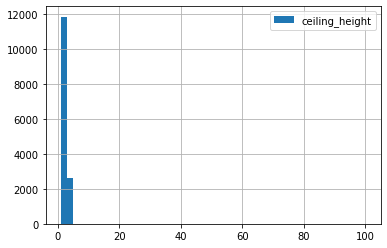

In [15]:
df['ceiling_height'].hist(bins=50, legend=True)

<div class="alert alert-block alert-warning">
 
### Комментарий ревьюера
    
#### Совет
    
А еще, не забывай давать графикам названия. Так будет понятно, что ты на них хочешь показать. 
</div 

**<font color="maroon">Добавил подписи к графикам</font>**

<div class="alert alert-block alert-success">
 
# Комментарий ревьюера ver.2
    
#### Успех
    
И тут супер 
</div 

In [16]:
df['ceiling_height'].value_counts()

2.50      3515
2.60      1646
2.70      1574
3.00      1112
2.80       993
2.55       980
2.75       910
2.65       676
3.20       277
3.10       203
2.90       164
3.30       141
2.56       139
3.50       130
2.57       103
2.85       101
3.40        92
2.54        83
2.64        81
2.52        79
2.53        67
2.58        63
2.77        61
2.76        60
3.15        57
2.78        51
2.95        47
3.05        46
4.00        39
3.25        36
3.60        36
2.67        36
2.73        35
2.51        34
2.72        31
3.70        30
2.74        28
2.68        23
2.40        23
3.80        20
2.84        19
3.55        18
2.82        18
2.66        17
3.12        17
3.35        16
2.45        15
2.83        15
2.59        14
2.62        14
3.90        14
3.08        14
2.71        13
2.63        13
2.88        12
2.00        11
3.18        11
3.13        11
3.06        11
3.07        11
3.33        10
2.87        10
2.79        10
4.20        10
2.81         9
2.92         9
3.45      

<AxesSubplot:>

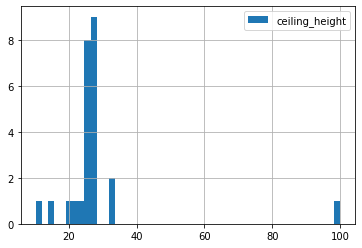

In [17]:
df[(df['ceiling_height']>10)]['ceiling_height'].hist(bins=50, legend=True)

<AxesSubplot:>

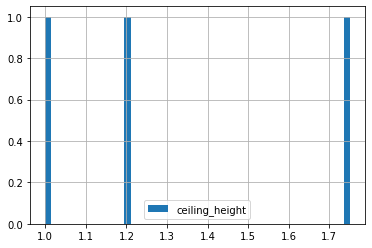

In [18]:
df[(df['ceiling_height']<2)]['ceiling_height'].hist(bins=50, legend=True)

In [19]:
df.loc[df['ceiling_height']>=10, 'ceiling_height'] /= 10 #если высота потолка >10 делим её на 10
df.shape

(23699, 24)

In [20]:
df = df[(df['ceiling_height'].isna())|(df['ceiling_height']>=2.2)] #удаляем все квартиры с высотой потолков до 2.2 м
df.shape

(23682, 24)

In [21]:
#df[df['ceiling_height']>3.5]['last_price'].count() 
df = df[(df['ceiling_height'].isna())|(df['ceiling_height']<=3.5)] #удаляем все квартиры с высотой потолков до 3.5 м как аномально-редкие

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Тут хорошо проработал с выбросами. 
</div 

In [22]:
median_ceil = df['ceiling_height'].median()
df['ceiling_height'] = df['ceiling_height'].fillna(median_ceil) #заменяем пропуски на медиану, т.к. предположительно пропуск подразумевает стандартные потолки
df['ceiling_height'].isna().sum()

0

<AxesSubplot:>

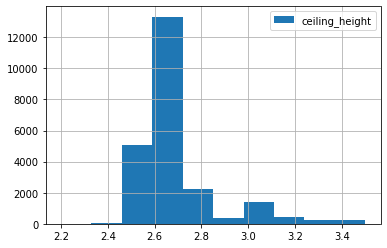

In [23]:
df['ceiling_height'].hist(bins=10, legend=True) 

In [24]:
df.shape

(23402, 24)

**Столбец цена квартиры**

<AxesSubplot:>

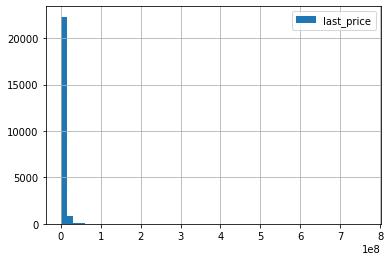

In [25]:
df['last_price'].hist(bins=50, legend=True)

In [26]:
df[df['last_price']>1e8]['last_price'].count()

26

<AxesSubplot:>

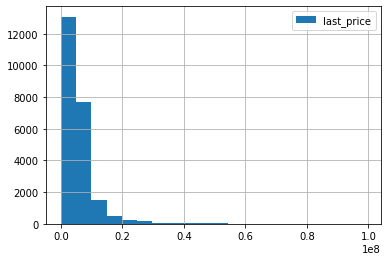

In [27]:
df = df[df['last_price']<=1e8] #удаляем квартиры стоимостью более 100 млн как аномально дорогие, их всего 26 шт
df['last_price'].hist(bins=20, legend=True)

<AxesSubplot:>

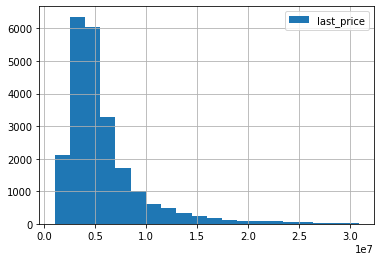

In [28]:
q1 = df['last_price'].quantile(0.01)
q2 = df['last_price'].quantile(0.99)
df = df[df['last_price'].between(q1,q2)] #удаляем 1% самых маленьких, и 1% самых больших значений
df['last_price'].hist(bins=20, legend=True) #итоговая гистограмма цен на квартиры

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Да, вот и тут согласен. Уберем супер редкие значения. 
</div 

In [29]:
df['last_price'].describe() #медианная стоимость квартиры 4,6 млн

count    2.291800e+04
mean     5.740427e+06
std      3.986554e+06
min      1.000000e+06
25%      3.450000e+06
50%      4.600000e+06
75%      6.600000e+06
max      3.089900e+07
Name: last_price, dtype: float64

**Столбец общая площадь квартиры**

In [30]:
df['total_area'].describe()

count    22918.000000
mean        58.090066
std         27.905388
min         12.000000
25%         40.000000
50%         51.500000
75%         68.000000
max        460.800000
Name: total_area, dtype: float64

<AxesSubplot:>

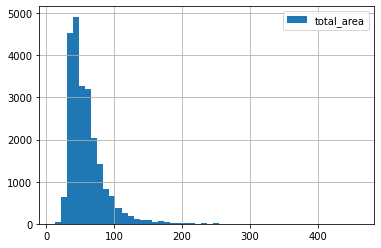

In [31]:
df['total_area'].hist(bins=50, legend=True)

<AxesSubplot:>

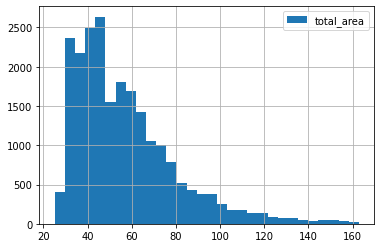

In [32]:
q1 = df['total_area'].quantile(0.01)
q2 = df['total_area'].quantile(0.99)
df = df[(df['total_area'].between(q1,q2))|(df['total_area'].isna())]
#удаляем 1% самых маленьких, и 1% самых больших значений, не трогаем пропуски
df['total_area'].hist(bins=30, legend=True) #итоговая гистограмма площади квартир

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Тут тоже хорошо получилось. 
</div 

In [33]:
df['total_area'].describe()

count    22458.000000
mean        56.941488
std         23.108528
min         25.070000
25%         40.000000
50%         51.500000
75%         67.892500
max        162.900000
Name: total_area, dtype: float64

**Столбец days_exposition**

In [34]:
df['days_exposition'].describe() #какая-то квартира продавалсь более 4 лет

count    19523.000000
mean       178.996005
std        217.535702
min          1.000000
25%         45.000000
50%         95.000000
75%        228.000000
max       1580.000000
Name: days_exposition, dtype: float64

<AxesSubplot:>

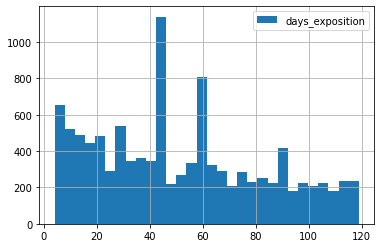

In [35]:
q1 = df['days_exposition'].quantile(0.01)
q2 = df['days_exposition'].quantile(0.99)
df = df[(df['days_exposition'].between(q1,q2))|(df['days_exposition'].isna())]
#удаляем 0,5% самых маленьких, и 0,5% самых больших значений, не трогаем пропуски
df[df.days_exposition<120]['days_exposition'].hist(bins=30, legend=True)

<div class="alert alert-block alert-warning">
 
### Комментарий ревьюера
    
#### Совет
    
Если ты посмотришь на график еще более детально, то заметишь выбросы в районе 45, 60 и 95 дней. В эти дни сайт убирает с продажи бесплатные объявления. 
</div 

**<font color="maroon">Не думаю, что надо избавляться от этих выбросов. Или надо? Если надо то как? Я не представляю.</font>**

<div class="alert alert-block alert-warning">
 
# Комментарий ревьюера ver.2
    
#### Совет
    
Тут на твое усмотрение, для идеального результата можно ограничить. 
</div 

In [36]:
df['days_exposition'].describe() #в среднем (медианно) квартиры продаются за 3 месяца

count    19171.000000
mean       169.909968
std        192.039442
min          4.000000
25%         45.000000
50%         94.000000
75%        223.000000
max       1059.000000
Name: days_exposition, dtype: float64

**Столбец расстояние от центра города**

In [37]:
df['cityCenters_nearest'].describe()

count    17015.000000
mean     14537.455951
std       8510.298191
min        287.000000
25%       9879.500000
50%      13297.000000
75%      16457.000000
max      65952.000000
Name: cityCenters_nearest, dtype: float64

<AxesSubplot:>

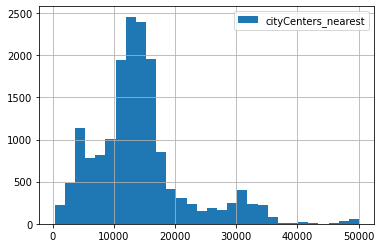

In [38]:
df = df[(df['cityCenters_nearest']<50100)|(df['cityCenters_nearest'].isna())] #удаляем 0,5% самых удалённых от центра квартир
df['cityCenters_nearest'].hist(bins=30, legend=True) 

In [39]:
df['cityCenters_nearest'].describe() #одна квартира удалена от центра на 50 км

count    16845.000000
mean     14156.014129
std       7649.208577
min        287.000000
25%       9839.000000
50%      13252.000000
75%      16298.000000
max      50075.000000
Name: cityCenters_nearest, dtype: float64

In [40]:
df.shape #после очитски осталось 21936 квартир в нашем датафрейме, т.е. удалено 7,5% строк.

(21936, 24)

<div class="alert alert-block alert-danger">
 
### Комментарий ревьюера
    
#### Ошибка
    
Вот тут похвалить не могу. Ты слишком увлекся удалением и убрал больше 30% от датафрейма. Всегда придерживайся правила 10%. Оно говорит о том, что если удаляем, то в районе 10%, иначе наши выводы могут быть искажены. Надо бы оставить больше данных. 
</div 

**<font color="maroon">Моя ошибка была в том что удалялись все NA значения. Исправил.</font>**

<div class="alert alert-block alert-success">
 
# Комментарий ревьюера ver.2
    
#### Успех
    
А сейчас получилось супер. Ошибку устранили. 
</div 

### Посчитайте и добавьте в таблицу новые столбцы

**Добавляем столбец цена 1 кв.м.**

<AxesSubplot:>

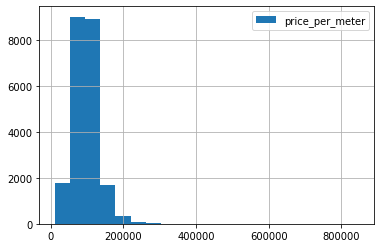

In [41]:
df['price_per_meter'] = df['last_price'] / df['total_area']
df['price_per_meter'].hist(bins=20, legend=True)

**Добавляем столбец день недели публикации объявления**

In [42]:
df['publicated_at_day_of_week'] = df['first_day_exposition'].dt.dayofweek
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,days_exposition_formatted,clean_locality_name,price_per_meter,publicated_at_day_of_week
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,16028.0,1.0,482.0,2.0,755.0,NaN,NaT,Санкт-Петербург,120370.370370,3
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,NaN,...,18603.0,0.0,NaN,0.0,NaN,81.0,81 days,Шушары,82920.792079,1
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,NaN,...,13933.0,1.0,90.0,2.0,574.0,558.0,558 days,Санкт-Петербург,92785.714286,3
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,8098.0,2.0,112.0,1.0,48.0,121.0,121 days,Санкт-Петербург,100000.000000,1
5,10,2890000.0,30.4,2018-09-10,1,2.65,12.0,14.4,5,NaN,...,NaN,NaN,NaN,NaN,NaN,55.0,55 days,Янино-1,95065.789474,0


**Добавляем столбец месяц публикации объявления**

In [43]:
df['publicated_at_month'] = df['first_day_exposition'].dt.month
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,days_exposition_formatted,clean_locality_name,price_per_meter,publicated_at_day_of_week,publicated_at_month
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,1.0,482.0,2.0,755.0,NaN,NaT,Санкт-Петербург,120370.370370,3,3
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,NaN,...,0.0,NaN,0.0,NaN,81.0,81 days,Шушары,82920.792079,1,12
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,NaN,...,1.0,90.0,2.0,574.0,558.0,558 days,Санкт-Петербург,92785.714286,3,8
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,2.0,112.0,1.0,48.0,121.0,121 days,Санкт-Петербург,100000.000000,1,6
5,10,2890000.0,30.4,2018-09-10,1,2.65,12.0,14.4,5,NaN,...,NaN,NaN,NaN,NaN,55.0,55 days,Янино-1,95065.789474,0,9


**Добавляем столбец год публикации объявления**

In [44]:
df['publicated_at_year'] = df['first_day_exposition'].dt.year
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,days_exposition_formatted,clean_locality_name,price_per_meter,publicated_at_day_of_week,publicated_at_month,publicated_at_year
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,482.0,2.0,755.0,NaN,NaT,Санкт-Петербург,120370.370370,3,3,2019
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,NaN,...,NaN,0.0,NaN,81.0,81 days,Шушары,82920.792079,1,12,2018
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,NaN,...,90.0,2.0,574.0,558.0,558 days,Санкт-Петербург,92785.714286,3,8,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,112.0,1.0,48.0,121.0,121 days,Санкт-Петербург,100000.000000,1,6,2018
5,10,2890000.0,30.4,2018-09-10,1,2.65,12.0,14.4,5,NaN,...,NaN,NaN,NaN,55.0,55 days,Янино-1,95065.789474,0,9,2018


<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
С переводом в формат даты все отлично получилось. 
</div 

**Добавляем столбец тип этажа**

In [45]:
def floor_type(floor, floors_total):
    if floor == 1: return 'Первый'
    elif floor == floors_total: return 'Последний'
    else: return 'Другой'
df['floor_type'] = df[['floor','floors_total']].apply(lambda x: floor_type(*x), axis=1)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,days_exposition_formatted,clean_locality_name,price_per_meter,publicated_at_day_of_week,publicated_at_month,publicated_at_year,floor_type
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,2.0,755.0,NaN,NaT,Санкт-Петербург,120370.370370,3,3,2019,Другой
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,NaN,...,0.0,NaN,81.0,81 days,Шушары,82920.792079,1,12,2018,Первый
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,NaN,...,2.0,574.0,558.0,558 days,Санкт-Петербург,92785.714286,3,8,2015,Другой
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,1.0,48.0,121.0,121 days,Санкт-Петербург,100000.000000,1,6,2018,Другой
5,10,2890000.0,30.4,2018-09-10,1,2.65,12.0,14.4,5,NaN,...,NaN,NaN,55.0,55 days,Янино-1,95065.789474,0,9,2018,Другой


**Добавляем столбец расстояние до центра города в километрах**

In [46]:
df['distance_km'] = (df['cityCenters_nearest']/1000).fillna(0).astype(int)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,days_exposition_formatted,clean_locality_name,price_per_meter,publicated_at_day_of_week,publicated_at_month,publicated_at_year,floor_type,distance_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,755.0,NaN,NaT,Санкт-Петербург,120370.370370,3,3,2019,Другой,16
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,NaN,...,NaN,81.0,81 days,Шушары,82920.792079,1,12,2018,Первый,18
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,NaN,...,574.0,558.0,558 days,Санкт-Петербург,92785.714286,3,8,2015,Другой,13
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,48.0,121.0,121 days,Санкт-Петербург,100000.000000,1,6,2018,Другой,8
5,10,2890000.0,30.4,2018-09-10,1,2.65,12.0,14.4,5,NaN,...,NaN,55.0,55 days,Янино-1,95065.789474,0,9,2018,Другой,0


<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Супер. Данные подготовили и можем идти дальше.  
</div 

### Проведите исследовательский анализ данных

**4.1 Изучаем параметры квартир**

**Общая площадь**

<AxesSubplot:>

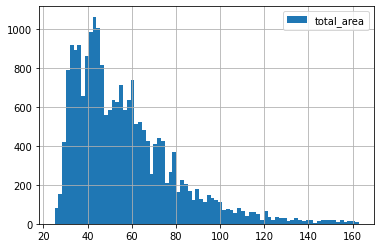

In [47]:
df['total_area'].hist(bins=80, legend=True)

In [48]:
df['total_area'].describe()

count    21936.000000
mean        56.927498
std         23.057594
min         25.070000
25%         40.000000
50%         51.500000
75%         67.900000
max        162.900000
Name: total_area, dtype: float64

В наших данных после очистки от аномамльных и редких значений представлены 21936 квартиры, общей площадью от 25 до 162 кв.м. Характер распределения я бы назвал нормальным, но тяготеющим в сторону минимальных значений. Маленьких квартир больше, чем просторных квартир.
Половина от всех квартир имеет общую площадь в диапазоне от 40 до 67 кв.м. Среднее значение - 57 кв.м.
Стандартное отклонение - 23 кв.м.
Медианное значение - 51,5 кв.м.

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
С выводами по графику согласен. 
</div 

**Жилая площадь**

<AxesSubplot:>

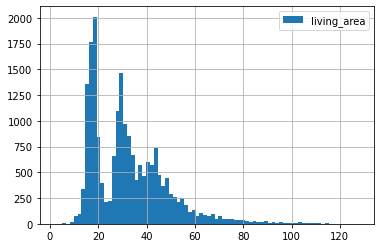

In [49]:
df['living_area'].hist(bins=80, legend=True)

In [50]:
df['living_area'].describe()

count    20214.000000
mean        32.473483
std         15.595997
min          2.000000
25%         18.600000
50%         30.000000
75%         41.600000
max        128.000000
Name: living_area, dtype: float64

Информация о жилой площади имеется у 20214 квартир. Как и в случае общей площади видим смещение распределения в сторону нуля. Кроме этого отчётливо наблюдаются пики или "горбы верблюда". Возможно так выражаются квартиры типовой застройки: первый горб - это множество квартир студий (может и коммуналок, это же Питер) с жилой площадью до 20 кв.м., второй горб - это вероятно однушки с жилой площадью 30(+-5) кв.м., пик около 40+ - это наверное двушки. Медианная жилая площадь составляет 30 кв.м. почему-то сильно меньше медианной общей площади в 52 кв.м. на целых 12 кв.м.

**Площадь кухни**

<AxesSubplot:>

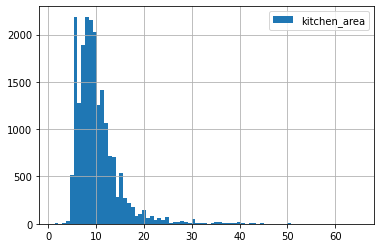

In [51]:
df['kitchen_area'].hist(bins=80, legend=True)

In [52]:
df['kitchen_area'].describe()

count    19984.000000
mean        10.207494
std          4.830850
min          1.300000
25%          7.000000
50%          9.000000
75%         11.700000
max         65.000000
Name: kitchen_area, dtype: float64

Площадь кухни указана в 19984 объявлениях. Среднее - 10,2 кв.м., стандартное отклонение - 4,83 кв.м., самая маленькая кухня - 1,3 кв.м., самая большая - 65 (скорее всего кухня-гостинная), половина значений расположено в диапазоне от 7 до 11,7 кв.м., мединное значение площади кухни - 9 кв.м.

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Ну и здесь тоже по делу. 
</div 

**Цена объекта**

<AxesSubplot:>

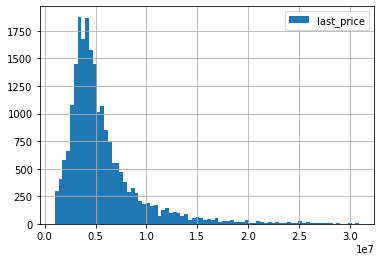

In [53]:
df['last_price'].hist(bins=80, legend=True)

In [54]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [55]:
df['last_price'].describe()

count      21936
mean     5621853
std      3669109
min      1000000
25%      3469150
50%      4600000
75%      6500000
max     30891300
Name: last_price, dtype: float64

Распределение стоимости квартир нормальное, но с жирным хвостом в сторону больших значений. Не знаю можно ли так выразиться? Среднее значение 5,6 млн, стандартное отклонение 3,7 млн - больше половины среднего говорит о большем разбросе значений, минимальная стоимость - 1 млн, максимальная стоимость 30,9 млн, мединная стоимость - 4,6 млн.

**Количество комнат**

<AxesSubplot:>

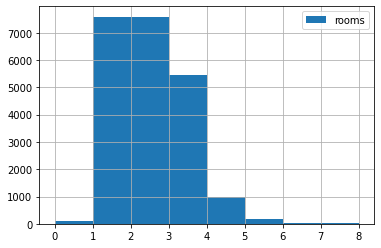

In [56]:
df['rooms'].hist(bins=8, legend=True)

In [57]:
df['rooms'].value_counts().sort_index()

0     115
1    7587
2    7559
3    5464
4     986
5     182
6      31
7      11
8       1
Name: rooms, dtype: int64

In [58]:
df['rooms'].describe()

count   21936
mean        2
std         1
min         0
25%         1
50%         2
75%         3
max         8
Name: rooms, dtype: float64

На рынке больше всего 1-комнатных квартир, затем двушек, трёшек и так далее, кроме этого обнаружено 115 объектов с 0 комнатами - вероятно коммуналки.

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
1-2 комнатные квартиры самые распространенные, что рядом с истиной. 
</div 

**Высота потолков**

<AxesSubplot:>

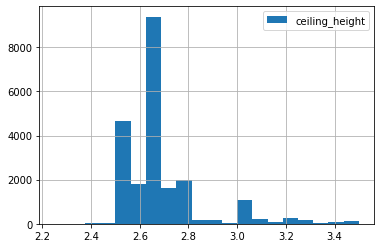

In [59]:
df['ceiling_height'].hist(bins=20, legend=True)

In [60]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)
df['ceiling_height'].describe()

count   21936.0
mean        2.7
std         0.2
min         2.2
25%         2.6
50%         2.6
75%         2.7
max         3.5
Name: ceiling_height, dtype: float64

Средняя и медианная высота потолков почти совпадают - 2,7 и 2,6 м соответственно, стандартное отклонение маленькое всего 0,2 м. Разброс значений высоты потолка минимальный. Но всё же встречаются объекты с высотой потолков от 2,2 до 3,5 м.

**Этаж квартиры**

<AxesSubplot:>

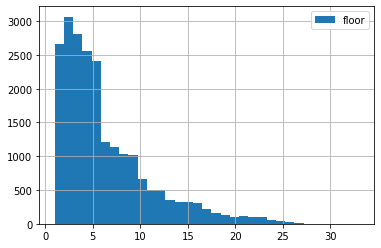

In [61]:
df['floor'].hist(bins=33, legend=True)

In [62]:
df['floor'].describe()

count   21936.0
mean        6.0
std         4.9
min         1.0
25%         2.0
50%         4.0
75%         8.0
max        33.0
Name: floor, dtype: float64

Больше всего квартир продаётся на этажах 1-5, количество квартир на 9 этаже тоже выбивается из тренда - всё это наверное отпечаток типового строительства 5-этажек и 9-этажек.

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Верные выводы по этому графику ты делаешь. 
</div 

**Тип этажа квартиры**

<AxesSubplot:>

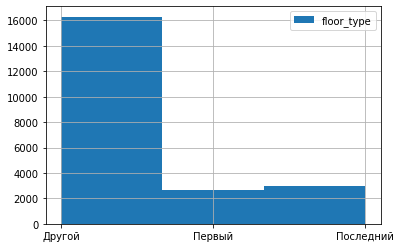

In [63]:
df['floor_type'].hist(bins=3, legend=True)

In [64]:
df['floor_type'].value_counts()

Другой       16299
Последний     2969
Первый        2668
Name: floor_type, dtype: int64

На первом этаже продаётся 2668 квартир, на последнем 2969 квартир, остальные 16299 квартир расположены на промежуточных этажах.

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Квартиры на 1-м этаже пользуются наименьшим спросом. 
</div 

**Общее количество этажей**

<AxesSubplot:>

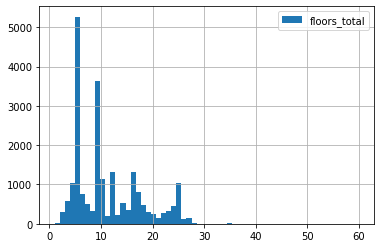

In [65]:
df['floors_total'].hist(bins=60, legend=True)

In [66]:
df['floors_total'].describe()

count   21859.0
mean       10.9
std         6.6
min         1.0
25%         5.0
50%         9.0
75%        16.0
max        60.0
Name: floors_total, dtype: float64

In [67]:
df['floors_total'].value_counts().sort_index()

1.0       18
2.0      299
3.0      570
4.0     1039
5.0     5269
6.0      747
7.0      516
8.0      319
9.0     3624
10.0    1129
11.0     186
12.0    1313
13.0     215
14.0     534
15.0     346
16.0    1320
17.0     806
18.0     475
19.0     310
20.0     261
21.0     147
22.0     274
23.0     331
24.0     444
25.0    1034
26.0     123
27.0     160
28.0      21
29.0       1
33.0       1
34.0       1
35.0      21
36.0       3
52.0       1
60.0       1
Name: floors_total, dtype: int64

Да как и предполагалось выше, мы тут видим пики на гистограмме - это наиболее распространённые типовые 5-этажки, 9-этажки, 12-этажки, 16-этажки и 25-этажки.

**Расстояние до центра города в метрах**

In [68]:
df['cityCenters_nearest'].describe()

count   16845.0
mean    14156.0
std      7649.2
min       287.0
25%      9839.0
50%     13252.0
75%     16298.0
max     50075.0
Name: cityCenters_nearest, dtype: float64

<AxesSubplot:>

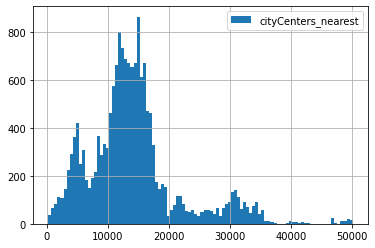

In [69]:
df['cityCenters_nearest'].hist(bins=100, legend=True)

В горбатом распределении расстояния до центра города, знающие Питер люди, наверное, могут выделить основные районы/посёлки/агломерации в районе Питера.

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Тоже верно. Соглашусь с тобой. 
</div 

**Расстояние до ближайшего аэропорта**

In [70]:
df['airports_nearest'].describe()

count   16825.0
mean    28650.8
std     12503.2
min         0.0
25%     18321.0
50%     26902.0
75%     37273.0
max     68338.0
Name: airports_nearest, dtype: float64

<AxesSubplot:>

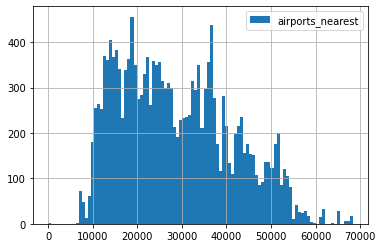

In [71]:
df['airports_nearest'].hist(bins=100, legend=True)

В среднем расстояние до ближайшего аэропорта - 28,6 км, стандартное отклонение - 12,5 км, одна квартира расположена прямо в каком-то аэропорту, расстояние 0, одна квартира рассположена на расстоянии в 68 км от аэропорта, медианное расстояние - 27 км.

**Расстояние до ближайшего парка**

In [72]:
df['parks_nearest'].describe()

count   7310.0
mean     495.7
std      340.7
min        1.0
25%      294.0
50%      458.0
75%      617.0
max     3190.0
Name: parks_nearest, dtype: float64

<AxesSubplot:>

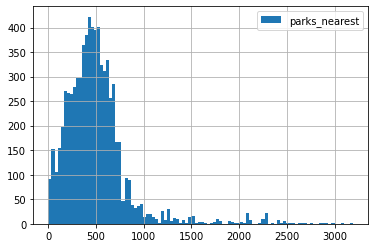

In [73]:
df['parks_nearest'].hist(bins=100, legend=True)

75% квартир расположены на расстоянии до 617 м до парка, что довольно близко по-моему, наверное очень много парков в Питере.

**День и месяц публикации объявления**

In [74]:
df['DD-MM'] = df['first_day_exposition'].dt.strftime('%d-%m') #добавим столбец день и месяц подачи объявления
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,days_exposition_formatted,clean_locality_name,price_per_meter,publicated_at_day_of_week,publicated_at_month,publicated_at_year,floor_type,distance_km,DD-MM
0,20,13000000.0,108.0,2019-03-07,3,2.7,16.0,51.0,8,NaN,...,NaN,NaT,Санкт-Петербург,120370.4,3,3,2019,Другой,16,07-03
1,7,3350000.0,40.4,2018-12-04,1,2.6,11.0,18.6,1,NaN,...,81.0,81 days,Шушары,82920.8,1,12,2018,Первый,18,04-12
2,10,5196000.0,56.0,2015-08-20,2,2.6,5.0,34.3,4,NaN,...,558.0,558 days,Санкт-Петербург,92785.7,3,8,2015,Другой,13,20-08
4,2,10000000.0,100.0,2018-06-19,2,3.0,14.0,32.0,13,NaN,...,121.0,121 days,Санкт-Петербург,100000.0,1,6,2018,Другой,8,19-06
5,10,2890000.0,30.4,2018-09-10,1,2.6,12.0,14.4,5,NaN,...,55.0,55 days,Янино-1,95065.8,0,9,2018,Другой,0,10-09


<AxesSubplot:>

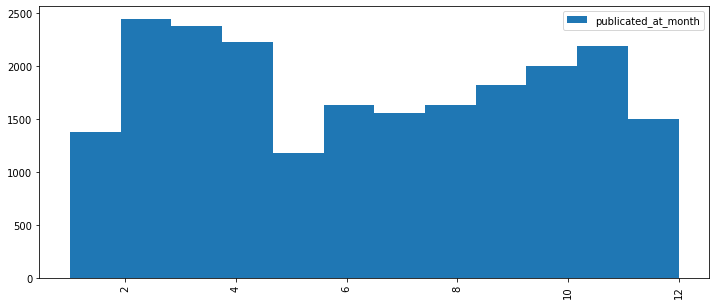

In [75]:
df['publicated_at_month'].hist(bins=12, figsize=(12, 5), grid=False, xrot=90, legend=True)

<div class="alert alert-block alert-danger">
 
### Комментарий ревьюера
    
#### Ошибка
    
Вот тут не пойдет так. Согласись, что на данных получилась мешанина, так как их очень много. Тут лучше не по датам на это смотерть, а хотя бы по месяцам. 
</div 

**<font color="maroon">Согласен. Заменил на месяца. Отчётливо видны провалы в декабре, январе и мае. Видимо люди не думают о продаже квартир в праздники.</font>**

In [76]:
df.groupby('DD-MM')['last_price'].count().sort_values()

DD-MM
31-12      7
03-01     11
24-12     12
02-01     12
07-05     13
04-01     13
29-02     14
31-01     15
29-12     15
09-05     16
04-06     16
07-01     18
06-01     19
08-05     19
23-09     19
28-05     19
26-08     20
14-05     20
05-11     21
21-05     23
11-06     23
08-01     24
02-12     24
06-05     25
23-12     25
28-12     25
14-01     26
27-01     26
12-08     27
25-12     27
20-05     27
28-10     27
30-12     27
15-07     27
13-06     28
27-05     28
22-07     28
02-09     28
27-12     29
29-07     29
12-06     30
19-08     30
30-09     30
08-03     31
05-01     32
04-02     32
26-12     32
07-10     32
29-05     32
24-09     32
13-07     32
02-05     33
23-05     33
16-09     33
20-08     34
22-12     34
30-01     34
10-06     34
28-07     34
28-01     34
05-06     34
03-06     34
31-05     35
13-05     36
23-02     37
06-02     37
04-11     38
10-05     38
05-08     38
22-10     39
30-11     39
21-12     39
18-06     39
27-08     39
11-08     39
20-12     39
09-07 

Меньше всего объявлений подаётся в праздничные дни, напрмер 31 декабря подано - 4 шт, даже на дату 29 февраля приходится больше объявлений - 11 шт. А вот 1 февраля и 10 ноября подано аномально много объявлений. Возможно это ошибка в данных.

**4.2. Скорость продажи**

In [77]:
df['days_exposition'].describe()

count   19028.0
mean      169.7
std       191.9
min         4.0
25%        45.0
50%        94.0
75%       222.0
max      1059.0
Name: days_exposition, dtype: float64

<AxesSubplot:>

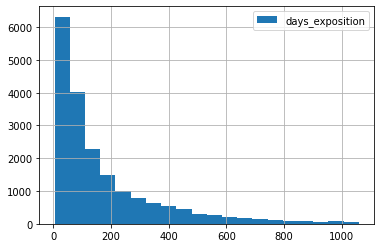

In [78]:
df['days_exposition'].hist(bins=20, legend=True)

- Средний срок продажи - 170 дней
- Медианный срок продажи - 94 дня
- Быстрыми можно назвать продажи в срок до трёх месяцев

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
В целом, согласен. 
</div 

**4.3. Факторы влияющие на стоимость**

In [79]:
df[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'floor_type']].corr()

,last_price,total_area,living_area,kitchen_area,rooms
last_price,1.0,0.8,0.6,0.6,0.5
total_area,0.8,1.0,0.9,0.5,0.8
living_area,0.6,0.9,1.0,0.3,0.9
kitchen_area,0.6,0.5,0.3,1.0,0.1
rooms,0.5,0.8,0.9,0.1,1.0


**<font color="maroon">Как видим, цена квартиры имеет корреляцию с общей площадью, чуть меньше корреляция от площади кухни и жилой площади, и ещё меньше зависит от количества комнат.</font>**

<div class="alert alert-block alert-danger">
 
### Комментарий ревьюера
    
#### Ошибка
    
От времени размещения она не будет зависеть, так как у них нет линейной связи. Отсюда надо убрать подсчет коррелации по времени. Зависимость надо смотреть для этого параметра просто по графику. 
</div 

**<font color="maroon">Понял. Принял. Сделал.</font>**

<div class="alert alert-block alert-success">
 
# Комментарий ревьюера ver.2
    
#### Успех
    
Идеально
</div 

**Зависимость цены от общей площади:**

In [80]:
df['total_area_groups'] = pd.qcut(df['total_area'],5)

In [81]:
df.groupby('total_area_groups')['last_price'].agg(['count','mean','median'])

,count,mean,median
total_area_groups,,,
"(25.069, 38.0]",4585,3277755.2,3280000.0
"(38.0, 45.8]",4201,3964950.4,3950000.0
"(45.8, 57.5]",4406,4659679.2,4610003.0
"(57.5, 72.9]",4365,5986142.5,5700000.0
"(72.9, 162.9]",4379,10270756.0,9000000.0


<AxesSubplot:xlabel='total_area_groups'>

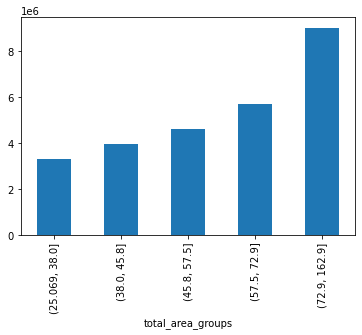

In [82]:
df.groupby('total_area_groups')['last_price'].median().plot(kind='bar') #График зависимости стоимости от общей площади

**Зависимость цены от жилой площади**

In [83]:
df['living_area_groups'] = pd.qcut(df['living_area'],5)
df.groupby('living_area_groups')['last_price'].agg(['count','mean','median'])

,count,mean,median
living_area_groups,,,
"(1.999, 18.0]",4650,3595821.0,3450000.0
"(18.0, 27.4]",3494,4308018.7,4090000.0
"(27.4, 33.0]",4132,4668819.0,4400000.0
"(33.0, 44.0]",4043,6212522.8,5600000.0
"(44.0, 128.0]",3895,9521861.3,8400000.0


<AxesSubplot:xlabel='living_area_groups'>

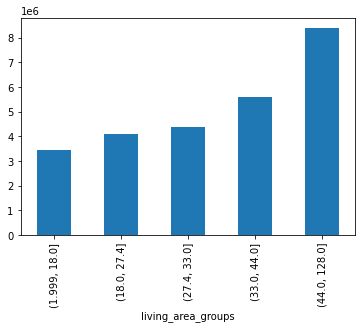

In [84]:
df.groupby('living_area_groups')['last_price'].median().plot(kind='bar') #График зависимости стоимости от жилой площади

**Зависимость цены от площади кухни**

In [85]:
df['kitchen_area_groups'] = pd.qcut(df['kitchen_area'],5)
df.groupby('kitchen_area_groups')['last_price'].agg(['count','mean','median'])

,count,mean,median
kitchen_area_groups,,,
"(1.2990000000000002, 6.8]",4031,3610123.9,3500000.0
"(6.8, 8.4]",4078,4508615.7,4250000.0
"(8.4, 10.0]",4180,4948627.6,4500000.0
"(10.0, 12.4]",3749,6033506.6,5300000.0
"(12.4, 65.0]",3946,9238878.6,7900000.0


<AxesSubplot:xlabel='kitchen_area_groups'>

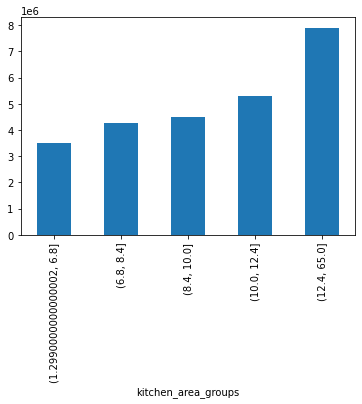

In [86]:
df.groupby('kitchen_area_groups')['last_price'].median().plot(kind='bar') #График зависимости стоимости от площади кухни

**Зависимость цены от количества комнат**

In [87]:
df.groupby('rooms')['last_price'].agg(['count','mean','median'])

,count,mean,median
rooms,,,
0,115,3228369.6,3000000.0
1,7587,3868367.9,3620000.0
2,7559,5474323.6,4800000.0
3,5464,7330113.6,6100000.0
4,986,9637655.4,8290000.0
5,182,11340564.1,10750000.0
6,31,12321612.9,12000000.0
7,11,18496363.6,15350000.0
8,1,16100000.0,16100000.0


<AxesSubplot:xlabel='rooms'>

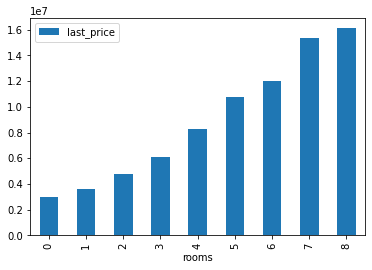

In [88]:
df.groupby('rooms')['last_price'].median().plot(kind='bar', legend=True) #График зависимости стоимости от количества комнат

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Тут логично, чем дороже квартира, тем и комнат больше. 
</div 

**Зависимость цены от этажа**

In [89]:
df.groupby('floor_type')['last_price'].agg(['count','mean','median'])

,count,mean,median
floor_type,,,
Другой,16299,5853734.3,4800000.0
Первый,2668,4567652.2,3950067.0
Последний,2969,5296211.2,4250000.0


<AxesSubplot:xlabel='floor_type'>

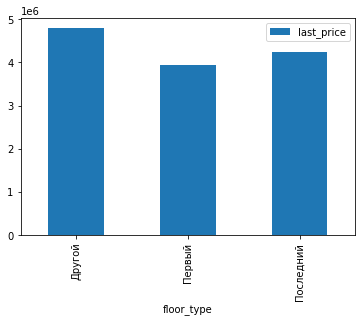

In [90]:
df.groupby('floor_type')['last_price'].median().plot(kind='bar', legend=True) #График зависимости стоимости от типа этажа

<AxesSubplot:xlabel='floor_type'>

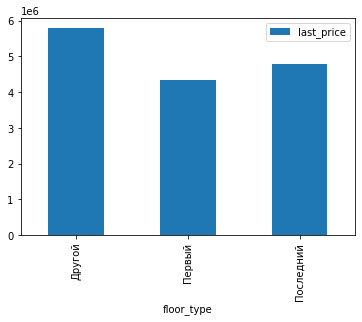

In [91]:
df[df['rooms'].between(2,4)].groupby('floor_type')['last_price'].median().plot(kind='bar', legend=True) #отдельно для двух-четырёхкомнатных квартир

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
На первом этаже самые недорогие квартиры. Логично. 
</div 

**Зависимость цены от дня недели подачи объявления** **<font color="maroon">Новое</font>**

<AxesSubplot:xlabel='publicated_at_day_of_week'>

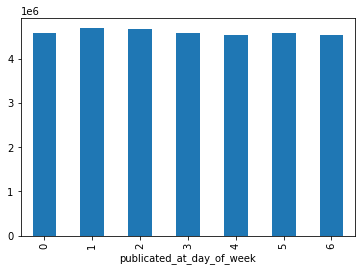

In [99]:
df.groupby('publicated_at_day_of_week')['last_price'].median().plot(kind='bar', legend=False)

**<font color="maroon">Судя по графику, во вторник и среду публикуются объявления о продаже чуть более дорогих квартир, чем в остальные дни недели</font>**

**Зависимость цены от месяца подачи объявления** **<font color="maroon">Новое</font>**

<AxesSubplot:xlabel='publicated_at_month'>

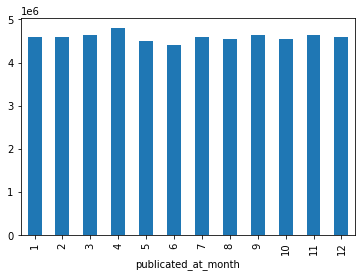

In [101]:
df.groupby('publicated_at_month')['last_price'].median().plot(kind='bar', legend=False)

**<font color="maroon">Самые дорогие квартиры публикуются в апреле, в начале лета в мае и июне дорогие квартиры публикуются реже чем в среднем по году</font>**

**Зависимость цены от года подачи объявления** **<font color="maroon">Новое</font>**

<AxesSubplot:xlabel='publicated_at_year'>

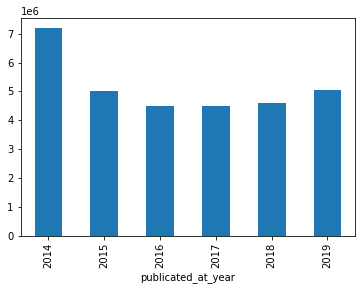

In [104]:
df.groupby('publicated_at_year')['last_price'].median().plot(kind='bar', legend=False)

**<font color="maroon">А вот это неожиданно. Цена на квартиры падала с 2014 по 2016 гг. Не ошибка ли это в данных? Или цены были пересчитаны по курсу доллара?</font>**

<div class="alert alert-block alert-success">
 
# Комментарий ревьюера ver.2
    
#### Успех
    
Тут скорее привязка к курсу, ты прав. 
</div 

**4.4. Цены по населённым пунктам**

In [93]:
df.value_counts('clean_locality_name')[:10].index

Index(['Санкт-Петербург', 'Мурино', 'Кудрово', 'Шушары', 'Всеволожск',
       'Пушкин', 'Колпино', 'Парголово', 'Гатчина', 'Выборг'],
      dtype='object', name='clean_locality_name')

In [94]:
pd.set_option('max_columns', None)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,days_exposition_formatted,clean_locality_name,price_per_meter,publicated_at_day_of_week,publicated_at_month,publicated_at_year,floor_type,distance_km,DD-MM,total_area_groups,living_area_groups,kitchen_area_groups
0,20,13000000.0,108.0,2019-03-07,3,2.7,16.0,51.0,8,NaN,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,NaT,Санкт-Петербург,120370.4,3,3,2019,Другой,16,07-03,"(72.9, 162.9]","(44.0, 128.0]","(12.4, 65.0]"
1,7,3350000.0,40.4,2018-12-04,1,2.6,11.0,18.6,1,NaN,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,81 days,Шушары,82920.8,1,12,2018,Первый,18,04-12,"(38.0, 45.8]","(18.0, 27.4]","(10.0, 12.4]"
2,10,5196000.0,56.0,2015-08-20,2,2.6,5.0,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,558 days,Санкт-Петербург,92785.7,3,8,2015,Другой,13,20-08,"(45.8, 57.5]","(33.0, 44.0]","(6.8, 8.4]"
4,2,10000000.0,100.0,2018-06-19,2,3.0,14.0,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,121 days,Санкт-Петербург,100000.0,1,6,2018,Другой,8,19-06,"(72.9, 162.9]","(27.4, 33.0]","(12.4, 65.0]"
5,10,2890000.0,30.4,2018-09-10,1,2.6,12.0,14.4,5,NaN,False,False,9.1,0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,55 days,Янино-1,95065.8,0,9,2018,Другой,0,10-09,"(25.069, 38.0]","(1.999, 18.0]","(8.4, 10.0]"


In [95]:
df[df['clean_locality_name'].isin(df.value_counts('clean_locality_name')[:10].index)].groupby('clean_locality_name')['price_per_meter'].agg(['count','median']).sort_values('count', ascending=False)

,count,median
clean_locality_name,,
Санкт-Петербург,14627,103921.6
Мурино,544,84255.7
Кудрово,435,94972.1
Шушары,426,76573.5
Всеволожск,388,65789.5
Пушкин,352,99865.7
Колпино,330,74689.9
Парголово,320,91579.7
Гатчина,302,67860.6


<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Топ-10 определен. Супер. 
</div 

In [96]:
df.groupby('clean_locality_name')['price_per_meter'].agg(['count','median']).sort_values('median')

,count,median
clean_locality_name,,
Житково,1,15648.3
Сланцы,29,19230.8
Никольский,3,19298.2
Бокситогорск,2,19600.1
Лесогорский,5,19833.3
Оредеж,1,19877.7
Торковичи,3,20458.9
Пикалёво,7,20905.9
Кисельня,1,20909.1


Если не брать во внимание населённые пункты где количество единичные объявления то самая высокая медианная стоимость квадратного метра в Санкт-Петербурге, а самая низкая - поселке Понтонный.

**4.5. Зависимость цены от расстояния до центра по г.Санкт-Петербург**

In [97]:
q = df[df['clean_locality_name']=='Санкт-Петербург'].groupby('distance_km')['price_per_meter'].agg(['count','median'])
q[q['count']>5]

,count,median
distance_km,,
0,100,119546.2
1,177,117449.7
2,217,112195.1
3,441,108214.3
4,734,124732.2
5,615,122881.4
6,403,126847.3
7,362,122858.2
8,634,112903.2


<AxesSubplot:xlabel='distance_km'>

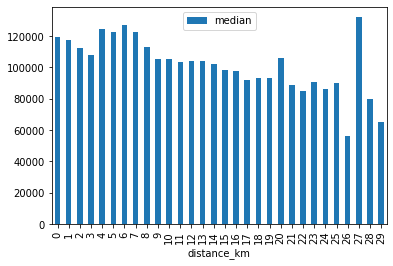

In [98]:
q.plot(kind='bar', y='median', use_index=True, legend=True) #График зависимости стоимости кв.метра от расстояния по г.Санкт-Петербург

С удалением от центра наблюдается снижение стоимости кв.метра жилья, но из правила есть исключения, скорее всего эти аномалии связаны с районами элитной недвижимости, и с неблагополучными районами.

<div class="alert alert-block alert-warning">
 
### Комментарий ревьюера
    
#### Совет
    
Как думаешь, а каким километражом ограничивается центр города? 
</div 

**<font color="maroon">Судя по графику зависимости цены квартир от расстояния от центра, вернее по резкому падению цены на рубеже 8-9 км, центр города ограничивается 8-ми километрами. Хотя непонятно тогда что за провал на 3 километрах. Я не был и не знаком с Питером, но могу предположить, что этот провал связан с низким спросом на на жильё на островах в центре города. В 27 километрах от центра видимо есть скопление супердорогих квартир.</font>**

### Общий вывод

Средний (медианный) объект выглядит так:
2-х комнатная квартира, с высотой потолков 2,6 м, общей площадью 51,5 кв.м., расположена на 5 этаже девяти этажного дома.
Расположена наша средняя квартира в 13 км от центра, в 27 км от аэропорта, и всего в 450 метрах от ближайшего парка.
- Медианная стоимость квартиры по выборке - 4,6 млн
- Медианный срок продажи по выборке - 3 мес

- Чем больше общая_площадь/жилая площадь/площадь_кухни тем квартира дороже
- На первом и последнем этажах квартиры несколько дешевле чем на промежуточных этажах
- Чем больше комнат в квартире тем она дороже
- Чем дальше от центра тем дешевле, но есть исключения
- В пригородных населённых пунктах цена кв.метра ниже чем в Санкт-Петербурге
- **<font color="maroon">С 2014 по 2016 наблюдался значительное снижение стоимости квартир.</font>**

**<font color="maroon">Рекомендации:</font>**
В данных много пропусков в картографических данных. Чтобы в будущем минимизировать эти пропуски в данных, с целью повышения качества анализа, я бы рекомендовал использовать данные геолокации, по возможности.
Чтобы избежать пропусков в графе высота потолка можно добавить для пользователей галочку "стандартная высота потолка".
Чтобы избежать пропусков в графе is_apartment можно было бы добавить подсказку пользователям, что считается апратаментами. Я, например, не знаю что такое апартаменты. Я, конечно, погуглил в яндексе, но всё равно каша в голове по этой теме.
Что касается колонок площадь кухни, количество балконов, то так же можно было бы добавить галочку "без кухни", "совмещённая кухня", "без балкона".

**<font color="maroon">Спасибо, Вячеслав! За подсказки, наводящие вопросы, и похвалу, это подбадривает</font>**

<div class="alert alert-block alert-success">
 
# Комментарий ревьюера ver.2
    
#### Успех
    
Ты это заслуижл. 
</div 

<div class="alert alert-block alert-danger">
 
### Комментарий ревьюера
    
#### Ошибка
    
В целом, вывод хороший и информативный получился. Надо бы добавить рекомендации и пару слов о пропусках. Что мы можем сделать, чтобы минимизировать их в дальнейшем? 
</div 

<div class="alert alert-block alert-info">
 
### Итоговый комментарий ревьюера
    
#### Успех
    
Спасибо тебе за проделанную работу. У тебя, определенно, есть хорошая база, при помощи который ты здорово справился с работой. Отдельно хочу похвалить за работу с Исследовательским анализом. Отдельного внимания заслуживает раздел, где ты проходишься по каждому столбцу и смотришь выбивающиесчя значения. А еще классный вывод получился, только надо чуть дополнить.
    
Но в работе есть замечания, которые надо будет поправить: 
    
* Добавить предположения по поводу пропусков.
* Оставить в проекте больше данных и подправить выводы. 
* Убрать подсчет коррелиции от времени размещения.
* Дополнить вывод.
  
    
А еще, я оставил в работе рекомендации. Надеюсь, они тебе помогут в дальнейшем.
    
Буду ждать проект после доработок. Удачи. 
</div 

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод